# Feature extraction using VGG16

In [4]:
#system tools
import os

# tf tools
import tensorflow as tf

# image processsing
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)
# VGG16 model
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)
# cifar10 data - 32x32
from tensorflow.keras.datasets import cifar10

# layers
from tensorflow.keras.layers import (Flatten, 
                                     Dense, 
                                     Dropout, 
                                     BatchNormalization)
# generic model object
from tensorflow.keras.models import Model

# optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD

#scikit-learn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# for plotting
import numpy as np
import matplotlib.pyplot as plt

## Plotting function (from last week)

In [2]:
def plot_history(H, epochs):
    plt.style.use("seaborn-colorblind")

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss", linestyle=":")
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc", linestyle=":")
    plt.title("Accuracy curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend()
    plt.show()

## Initialize the model

In [59]:
tf.keras.backend.clear_session()

# load model
model = VGG16()

__Preprocessing__

Keras provides some tools to help with this step.

First, we can use the ```load_img()``` function to load the image and resize it to the required size of 224×224 pixels. This is only the required size for vgg16. For other models, the size required in the input is different.

In [28]:
filepath = os.path.join('..', '..', '..', 'CDS-VIS', 'img', 'clonazepam_1mg.png')

In [29]:
image = load_img(filepath, target_size = (224, 224))

Next, we can convert the pixels to a NumPy array so that we can work with it in Keras. 

We can use the ```img_to_array()``` function for this.

In [30]:
image = img_to_array(image)

The network expects one or more images as input; that means the input array will need to be 4-dimensional: samples, rows, columns, and channels.

We only have one sample (one image). We can reshape the array by calling ```reshape()``` and adding the extra dimension.

In [31]:
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) 

Next, the image pixels need to be prepared in the same way as the ImageNet training data was prepared. Specifically, from the paper:

>The only preprocessing we do is subtracting the mean RGB value, computed on the training set, from each pixel. 

See the paper [here](https://arxiv.org/abs/1409.1556).

In [32]:
image = preprocess_input(image)

## Make prediction using ImageNet labels

We then use the model to predict our image class and convert probabilities to class labels using ```decode_predictions()```.

In [33]:
# predict probs across all classes
y_pred = model.predict(image)

__Inspect most likely label__

In [34]:
# convert probs to class labels
label = decode_predictions(y_pred)
label

[[('n04116512', 'rubber_eraser', 0.4176538),
  ('n03929660', 'pick', 0.3117712),
  ('n02786058', 'Band_Aid', 0.042988233),
  ('n03047690', 'clog', 0.027903676),
  ('n03775071', 'mitten', 0.020075304)]]

## Finetune on new task

We import the regular cifar10 dataset from ```keras``` and normalise.

In [60]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# normalize
X_train = X_train/255
X_test = X_test/255

__Binarize labels__

In [61]:
#create one-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

# initialize label names
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

__Check tensor shape__

In [62]:
X_train.shape # the tensor shape has 4 values, so all good (sample, height, width, channels)

(50000, 32, 32, 3)

__Load VGG16 *without* the classification layers__

Here we're just loading the convolutional layers and not the final classification network, using the argument ```include_top=False```

We also redefine the input shape, to work better with our cifar10 data.

In [63]:
# loading without classification layer
model = VGG16(include_top = False, # remove classifier
              pooling = 'avg', # optimizer
              input_shape = (32, 32, 3)) # define our new images input shape

__Disable training of Conv layers__

We need to disable the convolutional layers before training. Why?

In [64]:
# make each layer non trainable (frozen)
for layer in model.layers:
    layer.trainable = False

In [65]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

__Add new classification layers__

We now add new classification layers after the convolutional layers.

Notice how here we are not using the ```Sequential```, so we have to explicitly name the preceding layer in the model!

In [57]:
tf.keras.backend.clear_session() # run this if you mess up your model and load it again. every time model is called, we add to the existing model. sor unning the same cell twice, will ruin the model

In [66]:
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output) # second part of this line, is the input the new flatten layer should take.
class1 = Dense(128, activation = 'relu')(flat1)
output = Dense(10, activation = 'softmax')(class1)

# define new model
model = Model(inputs = model.inputs,
              outputs = output)

# summarize
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

__Compile__

We're going to be using a more sophisticated optimization algorithm, which you can read about [here](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay).

In [68]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay( # the decrease is by an exponential curve
    initial_learning_rate = 0.01, # high learning rate initially
    decay_steps = 10000, # num of steps
    decay_rate = 0.9) # how much to decrayse by 

sgd = SGD(learning_rate = lr_schedule)

In [69]:
model.compile(optimizer = sgd,
              loss = 'categorical_crossentropy', # multi class instead of binary
              metrics = ['accuracy']) 

__Train__

In [70]:
H = model.fit(X_train, y_train,
              validation_data = (X_test, y_test),
              batch_size = 128,
              epochs = 10,
              verbose = 1) # verbose true: tell me information while running

Epoch 1/10
391/391 [==============================] - 48s 123ms/step - loss: 1.9940 - accuracy: 0.3139 - val_loss: 1.7930 - val_accuracy: 0.3932
Epoch 2/10
391/391 [==============================] - 47s 120ms/step - loss: 1.6889 - accuracy: 0.4290 - val_loss: 1.6185 - val_accuracy: 0.4471
Epoch 3/10
391/391 [==============================] - 48s 123ms/step - loss: 1.5639 - accuracy: 0.4641 - val_loss: 1.5364 - val_accuracy: 0.4725
Epoch 4/10
391/391 [==============================] - 48s 123ms/step - loss: 1.4949 - accuracy: 0.4874 - val_loss: 1.4891 - val_accuracy: 0.4834
Epoch 5/10
391/391 [==============================] - 48s 122ms/step - loss: 1.4486 - accuracy: 0.5017 - val_loss: 1.4440 - val_accuracy: 0.4972
Epoch 6/10
391/391 [==============================] - 47s 120ms/step - loss: 1.4149 - accuracy: 0.5111 - val_loss: 1.4178 - val_accuracy: 0.5079
Epoch 7/10
391/391 [==============================] - 48s 122ms/step - loss: 1.3893 - accuracy: 0.5210 - val_loss: 1.3953 - val_ac

__Evaluate__

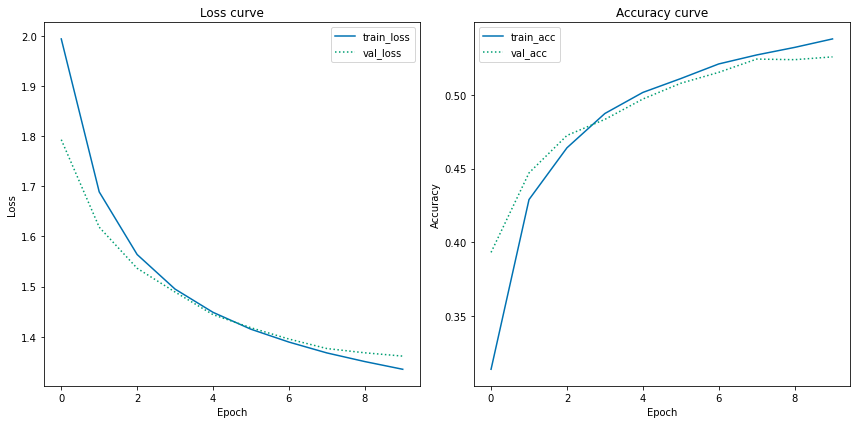

In [71]:
plot_history(H, 10)

In [72]:
predictions = model.predict(X_test, batch_size=128)
# print classification report
print(classification_report(y_test.argmax(axis=1), 
                            predictions.argmax(axis=1), 
                            target_names=label_names))

              precision    recall  f1-score   support

    airplane       0.56      0.63      0.59      1000
  automobile       0.54      0.58      0.56      1000
        bird       0.36      0.52      0.42      1000
         cat       0.42      0.37      0.39      1000
        deer       0.55      0.45      0.49      1000
         dog       0.58      0.42      0.48      1000
        frog       0.58      0.60      0.59      1000
       horse       0.63      0.51      0.57      1000
        ship       0.67      0.60      0.63      1000
       truck       0.48      0.59      0.53      1000

    accuracy                           0.53     10000
   macro avg       0.54      0.53      0.53     10000
weighted avg       0.54      0.53      0.53     10000



## Using data augmentation

__Reload model__

__Define data generator__

You can see the documentation for ImageDataGenerator [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

We're choosing to generate data on the fly, rather than save it to a folder.

__Train__

__Inspect__

__Evaluate__